# Projet numérique : Lignes de niveau

### Première étape : import des bibliothèques

In [12]:
import matplotlib.pyplot as plt
import autograd
from autograd import numpy as np
%matplotlib inline

## Amorce

On se sert de la continuité de f et du théorème des valeurs intermédiaires pour trouver une condition raisonnable sur c. En effet si f est continue sur [0,1] alors f prend toutes les valeurs sur l'intervalle [f(0,0),f(0,1)]. Ainsi si c $\in$ [f(0,0),f(0,1)] alors il existe obligatoirement t $\in$ [0,1] tel que f(0,t) = c. On se sert alors d'une méthode de dichotomie pour trouver la valeur de t.

In [13]:
def find_seed(g, c=0, eps=2**(-26)) :
    if (c >= g(0,0) and c <= g(0,1)) or (c <= g(0,0) and c >= g(0,1)) :
        #-----------------------------#
        def f(y) :
            return(g(0,y) - c)
            
        def dichotomie(f,a,b) :
            while abs(a - b) > eps :
                c = (a+b)/2
                if f(c)*f(a) > 0 :
                    a = c
                else :
                    b = c
            return(c)
        #------------------------------#
        t = dichotomie(f,0,1)
        return(t)
    else :
        return(None)

## Contour simple

Une fois que l'on a un point sur la frontière vérifiant $f(x,y) = c$, on cherche alors le gradient en ce point pour déterminer un vecteur tangent en ce point et alors se déplacer le long de la ligne de niveau grâce à des méthodes numériques d'intégration. Cette méthode est une bonne première approche même si elle implique des conditions de pas de quantification faible pour limiter l'erreur au niveau des points. 

In [14]:
def simple_contour(f, c=0.0, delta=0.01) :
    X = [] ; Y = []
    # Définition du gradient
    def grad_f(x,y) :
        g = autograd.grad
        grad = np.array([g(f,0)(x,y),g(f,1)(x,y)])
        return(grad/((grad[0]**2 + grad[1]**2)**(1/2)))  # On retourne un gradient normé
    # Recherche de t sur la frontière
    y = find_seed(f,c) ; x = 0.0
    if y != None :
        X.append(0) ; Y.append(y)
    else :
        return(X,Y)     # Cas où c n'est pas sur la frontière
    gf = grad_f(x,y)
    if gf[1] >= 0 :
        E = 1
    else :
        E = -1
    # Recherche de la ligne de niveau
    while x >= 0 and x <= 1 and y >= 0 and y <= 1 :
        gf = grad_f(x,y)
        x += E*gf[1]*delta ; y -= E*gf[0]*delta
        X.append(x) ; Y.append(y)
    
    X.pop() ; Y.pop() #le dernier point est hors du cadre
    return(X,Y)

### Fonctions de Test

In [15]:
def f(x,y) :
    return(2*(np.exp(-x**2-y**2) - np.exp(-(x-1)**2-(y-1)**2)))

def g(x,y) :
    return(x**2 + y**2)

On peut tester notre contour pour ces 2 fonctions.

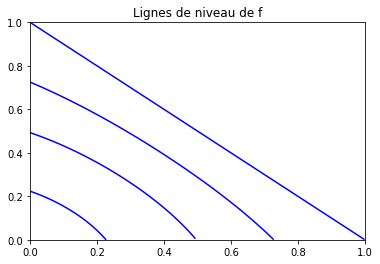

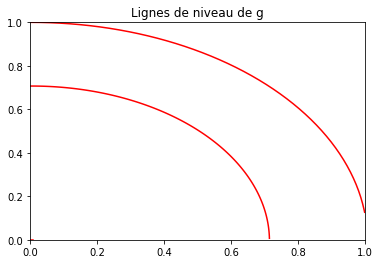

In [16]:
C = [-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5]

for c in C :
    x,y = simple_contour(f,c)
    plt.plot(x,y,'b')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Lignes de niveau de f")
plt.show()

for c in C :
    x,y = simple_contour(g,c)
    plt.plot(x,y,'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Lignes de niveau de g")
plt.show()

## Contour Complexe

### Recherche sur la frontière

On commence par définir une recherche de seed pour les 4 côtés de la cellule. On effectue le même raisonnement que dans l'amorce mais en l'adaptant à chaque côté de la frontière.

In [17]:
def seed_complexe(g, x0, x1, y0, y1, c=0.0, eps=2**(-26)) :
    T = []
    #---------Fonction pour la recherche de t-----------#
    def dichotomie(f,a,b) :
            while abs(a - b) > eps :
                c = (a+b)/2
                if f(c)*f(a) > 0 :
                    a = c
                else :
                    b = c
            return(c)
    #---------On cherche le seed sur les 4 côtés du carré-----------#
    if (c >= g(x0,y0) and c <= g(x0,y1)) or (c <= g(x0,y0) and c >= g(x0,y1)) :
        def f1(y) :
            return(g(x0,y) - c)
        t = dichotomie(f1,y0,y1)
        T.append([x0,t])
    #--------------------#   
    if (c >= g(x0,y0) and c <= g(x1,y0)) or (c <= g(x0,y0) and c >= g(x1,y0)) :
        def f2(x) :
            return(g(x,y0) - c)
        t = dichotomie(f2,x0,x1)
        T.append([t,y0])
    #--------------------#   
    if (c >= g(x1,y1) and c <= g(x1,y0)) or (c <= g(x1,y1) and c >= g(x1,y0)) :
        def f3(y) :
            return(g(x1,y) - c)
        t = dichotomie(f3,y0,y1)
        T.append([x1,t])
    #--------------------#
    if (c >= g(x1,y1) and c <= g(x0,y1)) or (c <= g(x1,y1) and c >= g(x0,y1)) :
        def f4(x) :
            return(g(x,y1) - c)
        t = dichotomie(f4,x0,x1)
        T.append([t,y1])
    return(T)

### Propagation sur un contour complexe

La fonction est quasiment identique à celle du contour simple sauf que l'on définit les arêtes de la cellule comme des variables. Il y a également en plus différents cas pour la recherche du vecteur unitaire orthogonal suivant la position du point sur la frontière. Une première limite apparait, on trace certaines lignes de niveaux 2 fois car on part de chacun de ses points sur le frontière. Autrement dit, on la trace dans les 2 sens ce qui ternit la lisibilité du graphe.

In [18]:
def cplx_contour(f, x0, x1, y0, y1, c=0.0, delta=0.01) :
    X = [] ; Y = []
    # Définition du gradient
    def grad_f(x,y) :
        g = autograd.grad
        grad = np.array([g(f,0)(x,y),g(f,1)(x,y)])
        return(grad/((grad[0]**2 + grad[1]**2)**(1/2)))  # On retourne un gradient unitaire
    # Recherche de t sur la frontière
    T = seed_complexe(f, x0, x1, y0, y1, c)
    for x,y in T :
        X.append(x) ; Y.append(y)
        gf = grad_f(x,y)
        # Il y a différentes conditions pour avoir un vecteur 
        # orthogonal au gradient dirigé vers l'intérieur du cadre
        if x == x0 :
            if gf[1] >= 0 :
                E = 1
            else :
                E = -1
        elif x == x1 :
            if gf[1] >= 0 :
                E = -1
            else :
                E = 1
        elif y == y0 :
            if gf[0] >= 0 :
                E = 1
            else :
                E = -1 
        else : 
            if gf[0] >= 0 :
                E = -1
            else :
                E = 1
        # Recherche de la ligne de niveau
        while x >= x0 and x <= x1 and y >= y0 and y <= y1 :
            gf = grad_f(x,y)
            x += E*gf[1]*delta ; y -= E*gf[0]*delta
            X.append(x) ; Y.append(y)
        X.pop() ; Y.pop() #le dernier point est hors du cadre
    return(X,Y)

La fonction contour permet de globaliser la fonction de contour complexe sur l'ensemble de définition. Il suffit juste de segmenter et de quadriller cet ensemble. 

In [19]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01) :
    xs = [] ; ys = []
    for i in range(len(xc)-1) :
        for j in range(len(yc)-1) :
            x,y = cplx_contour(f, xc[i], xc[i+1],yc[j],yc[j+1],c,delta)
            xs.append(x) ; ys.append(y)
    return(xs,ys)

### Test avec les fonctions

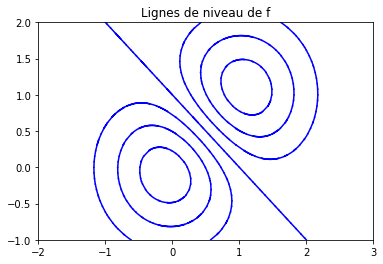

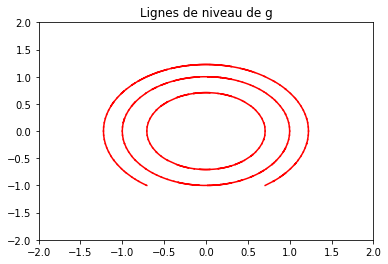

In [20]:
C = [-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5]
xc = np.linspace(-2,3,40)
yc = np.linspace(-1,2,40)

for c in C :
    xs,ys = contour(f, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'b')
plt.xlim(-2,3)
plt.ylim(-1,2)
plt.title("Lignes de niveau de f")
plt.show()

for c in C :
    xs,ys = contour(g, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'r')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Lignes de niveau de g")
plt.show()

### Limites de cette approche

1. On considère qu'il n'a qu'un seul contour par arête de la cellule. En effet, si ce n'est pas le cas, étant donné le fait que notre fonction find_seed ne détecte qu'un point, alors on risque de manquer une ligne de niveau. 
--> Si on prend des cellules suffisamment petites, ce risque devient très faible. On peut considérer qu'avec la majorité des fonctions, les cas avec 2 seed sur la même frontière seront très rare. 

2. Avec la méthode d'Euler que nous utilisons, l'erreur sur le tracé s'accumule rapidement. 
--> Mais encore une fois si on prend des cellules suffisamment petites l'erreur globale reste faible.

Le problème prinipal est donc la précision mais diminuer la taille des cellules augmente la durée de traitement, il faut donc trouver une méthode qui minimise l'erreur pendant l'exécution.

## Seconde Approche

### Recherche de seed

Nous avons remarqué qu'avec cette première méthode, on trace 2 fois les mêmes lignes de niveau sur une cellule. Nous nous sommes dit que l'on pouvait raisonnablement considérer qu'il n'existait qu'une seule solution à f(x,y) = c sur la frontière de cellule suffisamment petite. On modifie alors la fonction seed_complexe.

In [21]:
def seed_complexe(g, x0, x1, y0, y1, c=0.0, eps=2**(-26)) :
    #---------Fonction pour la recherche de t-----------#
    def dichotomie(f,a,b) :
            while abs(a - b) > eps :
                c = (a+b)/2
                if f(c)*f(a) > 0 :
                    a = c
                else :
                    b = c
            return(c)
    #---------On cherche le seed sur les 4 côtés du carré-----------#
    if (c >= g(x0,y0) and c <= g(x0,y1)) or (c <= g(x0,y0) and c >= g(x0,y1)) :
        def f1(y) :
            return(g(x0,y) - c)
        t = dichotomie(f1,y0,y1)
        return([x0,t])
    #--------------------#   
    elif (c >= g(x0,y0) and c <= g(x1,y0)) or (c <= g(x0,y0) and c >= g(x1,y0)) :
        def f2(x) :
            return(g(x,y0) - c)
        t = dichotomie(f2,x0,x1)
        return([t,y0])
    #--------------------#   
    elif (c >= g(x1,y1) and c <= g(x1,y0)) or (c <= g(x1,y1) and c >= g(x1,y0)) :
        def f3(y) :
            return(g(x1,y) - c)
        t = dichotomie(f3,y0,y1)
        return([x1,t])
    #--------------------#
    elif (c >= g(x1,y1) and c <= g(x0,y1)) or (c <= g(x1,y1) and c >= g(x0,y1)) :
        def f4(x) :
            return(g(x,y1) - c)
        t = dichotomie(f4,x0,x1)
        return([t,y1])
    else :
        return(None)

Cette nouvelle version permet de diviser la complexité spatiale et temporelle par 2 car on stocke et on traite 2 fois moins de valeurs.
Il faut également modifier la fonction cplx_contour.

In [22]:
def cplx_contour(f, x0, x1, y0, y1, c=0.0, delta=0.01) :
    X = [] ; Y = []
    # Définition du gradient
    def grad_f(x,y) :
        g = autograd.grad
        grad = np.array([g(f,0)(x,y),g(f,1)(x,y)])
        return(grad/((grad[0]**2 + grad[1]**2)**(1/2)))  # On retourne un gradient unitaire
    # Recherche de t sur la frontière
    T = seed_complexe(f, x0, x1, y0, y1, c)
    if T != None :
        x = T[0] ; y = T[1]
        X.append(x) ; Y.append(y)
        gf = grad_f(x,y)
        # Il y a différentes conditions pour avoir un vecteur 
        # orthogonal au gradient dirigé vers l'intérieur du cadre
        if x == x0 :
            if gf[1] >= 0 :
                E = 1
            else :
                E = -1
        elif x == x1 :
            if gf[1] >= 0 :
                E = -1
            else :
                E = 1
        elif y == y0 :
            if gf[0] >= 0 :
                E = 1
            else :
                E = -1 
        else : 
            if gf[0] >= 0 :
                E = -1
            else :
                E = 1
        # Recherche de la ligne de niveau
        while x >= x0 and x <= x1 and y >= y0 and y <= y1 :
            gf = grad_f(x,y)
            x += E*gf[1]*delta ; y -= E*gf[0]*delta
            X.append(x) ; Y.append(y)
        X.pop() ; Y.pop() #le dernier point est hors du cadre
    return(X,Y)

### Test

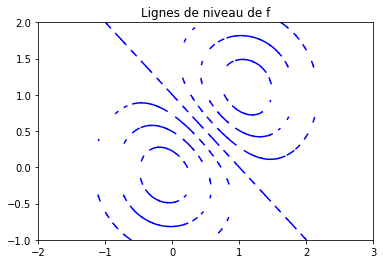

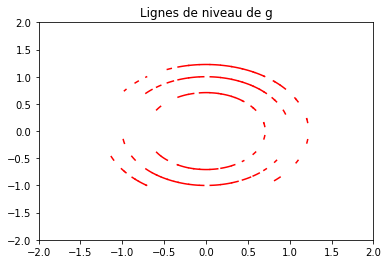

In [23]:
C = [-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5]
xc = np.linspace(-2,3,40)
yc = np.linspace(-1,2,40)

for c in C :
    xs,ys = contour(f, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'b')
plt.xlim(-2,3)
plt.ylim(-1,2)
plt.title("Lignes de niveau de f")
plt.show()

for c in C :
    xs,ys = contour(g, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'r')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Lignes de niveau de g")
plt.show()

On remarquera que les lignes de niveau sont discontinues, il y a donc un problème avec la recherche de seed sur la frontière. On décide alors pour la suite de revenir à notre ancienne fonction.

In [24]:
def seed_complexe(g, x0, x1, y0, y1, c=0.0, eps=2**(-26)) :
    #---------Fonction pour la recherche de t-----------#
    def dichotomie(f,a,b) :
            while abs(a - b) > eps :
                c = (a+b)/2
                if f(c)*f(a) > 0 :
                    a = c
                else :
                    b = c
            return(c)
    #---------On cherche le seed sur les 4 côtés du carré-----------#
    if (c >= g(x0,y0) and c <= g(x0,y1)) or (c <= g(x0,y0) and c >= g(x0,y1)) :
        def f1(y) :
            return(g(x0,y) - c)
        t = dichotomie(f1,y0,y1)
        return([x0,t])
    #--------------------#   
    if (c >= g(x0,y0) and c <= g(x1,y0)) or (c <= g(x0,y0) and c >= g(x1,y0)) :
        def f2(x) :
            return(g(x,y0) - c)
        t = dichotomie(f2,x0,x1)
        return([t,y0])
    #--------------------#   
    if (c >= g(x1,y1) and c <= g(x1,y0)) or (c <= g(x1,y1) and c >= g(x1,y0)) :
        def f3(y) :
            return(g(x1,y) - c)
        t = dichotomie(f3,y0,y1)
        return([x1,t])
    #--------------------#
    if (c >= g(x1,y1) and c <= g(x0,y1)) or (c <= g(x1,y1) and c >= g(x0,y1)) :
        def f4(x) :
            return(g(x,y1) - c)
        t = dichotomie(f4,x0,x1)
        return([t,y1])
    else :
        return(None)

### Atténuation de l'erreur

On va chercher à atténuer l'erreur lors de notre déplacement le long de la ligne de niveau pour essayer de trouver des valeurs qui donnent bien f(x,y) = c . On va alors, une fois que l'on s'est déplacé le long du vecteur normal, se déplacer suivant le gradient pour essayer de se rapprocher de la ligne de niveau. On définit alors cette fonction qui se rapproche d'une dichotomie :

In [25]:
def dichotomie2(f, c, x, y, gf, n, eps=2**(-26), delta=0.01) :
    if n == 0 :
        a = [x,y] ; b = [x+gf[0]*delta, y+gf[1]*delta]
    elif n == 1 :
        a = [x,y] ; b = [x-gf[0]*delta,y-gf[1]*delta]
    while abs(a[0] - b[0]) > eps and abs(a[1] - b[1]) > eps :
        m = [(a[0]+b[0])/2, (a[1]+b[1])/2]
        if (f(m[0],m[1]) - c)*(f(a[0],a[1]) - c) > 0 :
            a = m[:]
        else :
            b = m[:]
    return(m)

On peut alors modifier notre fonction de contour pour appliquer cette atténuation de l'erreur

In [28]:
def cplx_contour(f, x0, x1, y0, y1, c=0.0, delta=0.01) : # Fonction modifiée
    X = [] ; Y = []
    # Définition du gradient
    def grad_f(x,y) :
        g = autograd.grad
        grad = np.array([g(f,0)(x,y),g(f,1)(x,y)])
        if norme(grad) == 0:
            return grad
        else:
            return(grad/norme(grad))  # On retourne un gradient normé
    # Recherche de t sur la frontière
    T = seed_complexe(f, x0, x1, y0, y1, c)
    if T is not None :
        for x,y in T :
            X.append(x) ; Y.append(y)
            gf = grad_f(x,y)
            if norme(gf) == 0:
                return X,Y
            # Il y a différentes conditions pour avoir un vecteur 
            # orthogonal au gradient dirigé vers l'intérieur du cadre
            if x == x0 :
                if gf[1] >= 0 :
                    E = 1
                else :
                    E = -1
            elif x == x1 :
                if gf[1] >= 0 :
                    E = -1
                else :
                    E = 1
            elif y == y0 :
                if gf[0] >= 0 :
                    E = 1
                else :
                    E = -1 
            else : 
                if gf[0] >= 0 :
                    E = -1
                else :
                    E = 1
            # Recherche de la ligne de niveau
            while x >= x0 and x <= x1 and y >= y0 and y <= y1 :
                gf = grad_f(x,y)
                x += E*gf[1]*delta ; y -= E*gf[0]*delta
                # On se rapproche alors de la ligne de niveau
                if f(x,y) < c :
                    x,y = dichotomie2(f,c,x,y,gf,0)
                elif f(x,y) > c :
                    x,y = dichotomie2(f,c,x,y,grad_f(x,y),1)
                 
                X.append(x) ; Y.append(y)
            X.pop() ; Y.pop() #le dernier point est hors du cadre
    return(X,Y)

### Test

In [29]:
C = [-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5]
xc = np.linspace(-2,3,40)
yc = np.linspace(-1,2,40)

for c in C :
    xs,ys = contour(f, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'b')
plt.xlim(-2,3)
plt.ylim(-1,2)
plt.title("Lignes de niveau de f")
plt.show()

for c in C :
    xs,ys = contour(g, c, xc, yc)
    for x,y in zip(xs,ys) :
        plt.plot(x,y,'r')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Lignes de niveau de g")
plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object